# Cigna
# Meijer - Root Causes with no transcriptions
# BMO - Root Causes with some transcriptions

In [1]:
import boto3
import numpy as np
import pandas as pd
import warnings
import os
import sys
import matplotlib.pyplot as plt
import json, re
import pickle
import seaborn as sns
import logging
%matplotlib inline 

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
import multiprocessing as mp
from joblib import Parallel, delayed
from spellchecker import SpellChecker

In [3]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
from gensim import utils
from gensim import models
from gensim import matutils
import swifter

In [4]:
def print_dataframe(df):
    
    """
    Print or display the entire dataframe 
    
    Parameters
    ---------- 
    df: Dataframe
   
    Returns
    -------
    df: None
    
    """
    
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
        
    display(df)
    
    return None

## Word2Vec Model:

   - Averaging all vectors across all tokens/transcription
   - Idf-Weighted word embeddings
   - Doc2Vec

## Loading the Pretained Word2Vec Model

In [5]:
%%time 
wv = models.KeyedVectors.load_word2vec_format('../../gensim-data/GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 23.3 s, sys: 2.4 s, total: 25.7 s
Wall time: 25.7 s


## Read in Dataset

In [63]:
df = pd.read_pickle("../Data/pickle_files/BMO_allsegments_longest_transcript_retainedV2.pkl")

df.drop(["Segment_Start_Time","Segment_Stop_Time"],axis=1,inplace=True)
df.dropna(subset=["Transcripts", "Root_Cause"],axis=0,inplace=True)
df.replace({'Cspro_Comments':{np.nan:" "}}, inplace=True)
df.reset_index(drop=True,inplace=True)

df.head(1)

,Universal_ID,Segment_ID,Segment_Counts,Cspro_Topic,Cspro_Subtopic,Cspro_Comments,Transcripts,Root_Cause
0,357697686,6.860470e+18,1.0,Time and Labor - Time Entry,Vacation Time,vaccation time,"Hello, Welcome to Bank of Montreal. My name is...",Education/Request


In [64]:
len(df)

187

In [65]:
RC_sorted = sorted(Counter(df.Root_Cause).items(), key=lambda kv: kv[1])
RC_sorted = [(k,v) for k,v in RC_sorted if v<5]

for tup in RC_sorted:
    iter_count = 5 - tup[1]
    for i in range(iter_count):
        frame = df[df.Root_Cause == tup[0]].sample(n=1)
        df = pd.concat([df, frame], axis=0)

In [66]:
len(df)

192

In [67]:
df.isnull().sum()

Universal_ID      0
Segment_ID        0
Segment_Counts    0
Cspro_Topic       0
Cspro_Subtopic    0
Cspro_Comments    0
Transcripts       0
Root_Cause        0
dtype: int64

In [ ]:
"""df_sub = df.copy()[df.Root_Cause == "Education/Request"]

df.drop(df_sub.index, axis=0, inplace=True)

df = pd.concat([df_sub.sample(frac=0.5, random_state=99), df], axis=0)
df.reset_index(drop=True, inplace=True)"""

## Preparing Dataset For Modelling

In [8]:
set1 = set(list(STOPWORDS))
set2 = set(stopwords.words("english"))
filler_words = set(["uh","uhh","ohh","oh","ah","ahh","umm","umb","hmm","mhm", "huh","Um","er","err","ok","okay","hi","hello","please","may"])
stop_words = set1.union(set2).union(filler_words)
lemma = WordNetLemmatizer()
pattern = re.compile("[0-9_.-/]+")

with open("contractions_dict.json") as f:
    contractions_dict = json.load(f)

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

#### Two Versions of Preprocessing functions

1. Multiple loops Version with no Parallellism

In [9]:
def w2v_tokenize_text(text):
    tokens = []
    spell = SpellChecker()
    # expand contractions like I've to I have and so on
    text = expand_contractions(text)
    # tokenize transcripts into sentences
    for sent in nltk.sent_tokenize(text, language='english'):
        # remove punctuations if any
        sent = sent.translate(str.maketrans('', '', string.punctuation))
        # tokenize sentence into words
        for word in nltk.word_tokenize(sent, language='english'):
            if word.lower() in ['bmo','meijer','alight','covid','401k','ybr','upoint']:
                tokens.append(word.lower())
            else:
                # auto-correct mispelled words
                word = spell.correction(word)
                # ignore alpha-numeric characters with 401k as an exception
                if word.isalpha():
                    # ignore very short words & occurances of numbers
                    if (len(word) <=2) | (pattern.fullmatch(word) is not None) | isinstance(word, int):
                        continue
                    # ignore stop words
                    if word.lower() in stop_words:
                        continue
                    # lemmatize the tokens     
                    tokens.append(lemma.lemmatize(word.lower(), pos="v"))
    return tokens

- remove autocorrect process
- convert digits into word form
- remove cspro_notes

In [68]:
df["Concat_text"] = df.Transcripts + ". "+ df.Cspro_Comments

In [69]:
%%time
df['tokenized_list'] = df.Concat_text.swifter.apply(lambda x: w2v_tokenize_text(x))


CPU times: user 2min 47s, sys: 2.41 s, total: 2min 49s
Wall time: 2min 49s


2. Reduced-loops Multilple-functions Version with Parallelism

Didn't work

In [ ]:
def process_token_list(token_list):
    
    spell = SpellChecker()
    tokens = []
    
    for word in token_list:
        if word.lower() in ['bmo','meijer','alight','covid','401k','ybr','upoint']:
            tokens.append(word.lower())
        else:
            # auto-correct mispelled words
            word = spell.correction(word)
            # ignore alpha-numeric characters with 401k as an exception
            if word.isalpha():
                # ignore very short words & occurances of numbers
                if (len(word) <=2) | (pattern.fullmatch(word) is not None) | isinstance(word, int):
                    continue
                # ignore stop words
                if word.lower() in stop_words:
                    continue
                # lemmatize the tokens     
                tokens.append(lemma.lemmatize(word.lower(), pos="v"))
    return tokens

def tokenize_text(text):
    
    text = expand_contractions(text)
    
    sentence_generator = (sent.translate(str.maketrans('', '', string.punctuation)) 
                          for sent in nltk.sent_tokenize(text, language='english'))
    
    tokens_generator = [[word for word in nltk.word_tokenize(sent, language='english')] for sent in sentence_generator]
    
    prepocessed_token_list = Parallel(n_jobs=mp.cpu_count()-1)(delayed(process_token_list)(word_list) for word_list in tokens_generator)
    
    return [token for list_tokens in tokens_generator for token in list_tokens]

In [ ]:
%%time
df['tokenized_list'] = df.Transcripts.swifter.apply(lambda x: tokenize_text(x))

## Feature-Extraction Functions

In [19]:
def word_averaging(wv, words, non_normalized=False):
    
    all_words, mean, words_not_considered = set(), [], []

    for word in words:
        try:
            mean.append(wv.get_vector(word, norm=True))
            all_words.add(wv.key_to_index[word])
        except KeyError:
            words_not_considered.append(word)
            continue
                
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)
    
    if non_normalized:
        return np.array(mean).mean(axis=0)
    
    mean = matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean, all_words, words_not_considered


def word_averaging_list(wv, text_list, non_normalized=False):
    if non_normalized:
        return  np.vstack([word_averaging(wv, review, non_normalized=True) for review in text_list])
    return np.vstack([word_averaging(wv, review)[0] for review in text_list ])

def sentence_to_avg(token_list, wv):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    wv -- Gensim KeyedVector object mapping every word in a vocabulary into its 300-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (300,)
    """
    words_not_considered =[]
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = [token.lower() for token in token_list]
    
    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(wv.get_vector("random").shape)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for word in words:
        try:
            avg +=wv.get_vector(word)
        except KeyError:
            words_not_considered.append(word)
    avg = avg/len(words)
    
    return avg, words_not_considered

def  word_averaging_listV2(wv, text_list):
    return np.vstack([sentence_to_avg(review, wv)[0] for review in text_list ])

def tfidf_vectorize(series_of_token_lists):
    """Accepts the cleaned text as a series_of_token_lists"""
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stop_words)
    vector = vectorizer.fit_transform(series_of_token_lists.apply(lambda x:" ".join(x)).values)
    vector = pd.DataFrame(vector.toarray(),columns=vectorizer.get_feature_names())
    return vector

## Model Evaluation Functions

In [20]:
def score_model(X, y, model, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (accuracy) scores
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
    y = pd.Series(LabelEncoder().fit_transform(y))
    
    #RCs = sorted(Counter(y).items(), key=lambda kv: kv[1], reverse=True)
    #upsample_RCs = [rc[0] for rc in RCs[1:]]
    #len_sample = [round(0.7*RCs[0][1])]*len(RCs[1:])
    smoter = SMOTE(random_state=42, k_neighbors=3) # sampling_strategy={k:v for k,v in zip(upsample_RCs,len_sample)})
    
    entries = []
    fold_idx = 0
    
    for train_fold_index, val_fold_index in cv.split(X, y):
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], y[val_fold_index]
        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold, y_train_fold)
        # Get the Model Name
        model_name = model.__class__.__name__
        # Fit the model on the upsampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
        entries.append((model_name, fold_idx, score))
        fold_idx += 1
         
    return pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

def Parallel_CV_across_models(X, y, features="word2vec"):
    
    models = [LinearSVC(class_weight='balanced', random_state=0),
              XGBClassifier(n_estimators=200, max_depth=6),
              KNeighborsClassifier(n_jobs=1, algorithm='brute', metric='cosine' )]
    
    if features == "tf-idf":
        models = models[:-1]
        models.append(MultinomialNB(alpha=1e-2))
       
    results = Parallel(n_jobs=mp.cpu_count()-1)(delayed(score_model)(X, y, model) for model in models)
    cv_df = pd.concat(results, axis=0)
    
    # summarize performance
    cv_df_mean_accuracy = pd.DataFrame(cv_df.groupby(['model_name']).agg({'accuracy': ['mean', 'std']}).reset_index())
    cv_df_mean_accuracy.columns = ['_'.join(col) for col in cv_df_mean_accuracy.columns]
    print_dataframe(cv_df_mean_accuracy)
    print('\n')

    # Plot model performance
    plt.figure(figsize=(10,6)) 
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.ylim(0,1)
    plt.show()
    return cv_df

In [70]:
df.drop(df.index[df.tokenized_list.apply(len) == 0], axis=0, inplace=True)

### Random-Shuffle dataframe (test set is not biased by the most frequent Root Cause)

In [71]:
df = df.sample(frac=1).reset_index(drop=True)

### Get Tf-Idf Vectorized DataFrame

In [72]:
df_TfIdf = tfidf_vectorize(df.tokenized_list)

In [73]:
df_TfIdf.head()

,401k,abbandonato,ability,aboard,absence,absences,absense,absent,absolute,absolutely,absurd,accent,accept,acceptable,accessible,accident,accommodate,accomplish,accord,accordingly,account,accountant,accountthe,accrue,accumulate,accurate,accuse,acknowledge,act,action,activate,active,actively,actual,actually,acupuncture,adam,adama,adaptation,add,addition,additional,additionally,additions,address,adjust,adjustment,adjustments,admin,administer,administration,administrator,admit,adoption,advance,advantage,advent,advice,advices,advise,advisor,affect,affidavit,afford,afraid,afternoon,age,agency,agent,agents,ago,agood,agree,agreement,ahead,ahold,aid,airport,aku,alan,alarm,alberta,alert,alexander,alexis,alicia,alight,alley,alligator,allow,allowance,alpha,alphabets,alphanumeric,alrighty,alternate,alternative,alternatives,altogether,amanda,amaze,amber,amend,amendment,amendments,america,amigo,anakin,andrea,andrew,andshared,angela,angeles,angelo,anika,animal,anna,announce,announcement,annoy,annual,annually,answer,anthony,anybody,anybodys,anymore,anytime,anyways,aol,apart,apartment,apologies,apologise,apologize,app,apparently,appeal,appear,apple,applicable,application,applications,apply,appointment,apportion,appraisal,appreciate,approach,appropriately,approval,approve,approximate,approximately,apps,appstore,apr,april,arabella,arc,area,areas,argos,arman,arrange,arrangement,arrangements,arrest,arrive,arrow,article,ascend,ashley,aside,aspect,assemble,assign,assist,assistance,assistant,associate,assume,assurance,assure,attach,attachment,attachments,attempt,attend,attendance,attention,attestation,attractively,audio,audit,aug,august,authenticate,authentication,authority,authorization,authorize,auto,automatic,automatically,avail,available,avenue,average,avoid,aware,away,awesome,awhile,baby,backdate,background,backup,backwards,bad,balance,ball,banana,bank,banker,bar,barn,baron,bartles,base,baseless,basic,basically,basis,bat,bayview,beach,bear,beat,beautiful,bee,beg,begin,behalf,believe,belong,beneficiaries,benefit,best,bet,...,tomorrow,ton,tone,tool,topic,topics,toronto,toss,total,totally,touch,tourists,town,tracheal,track,tracker,trade,traditional,traffic,train,trainer,transaction,transactions,transf,transfer,transit,transition,translate,transport,trash,travel,treat,treatment,trend,trial,tricky,trigger,trip,triple,trouble,troubleshoot,trudy,true,truly,trust,tuesday,tuesdays,turn,turnaround,turnover,twentytwo,twice,type,typically,ultimate,ultimately,uma,unable,unacceptable,unapproved,unbaked,unbelief,unblock,uncle,uncounted,undergarment,undergo,underlie,underline,underpay,understand,understandable,understate,undue,unemployment,unexcused,unfair,unfortunately,unheard,uniform,unique,unit,units,unlock,unlucky,unnecessarily,unpaid,unrealistic,unrelated,unsuccessful,unused,upcoming,update,upgrade,uphold,upload,upper,uppercase,upset,upstairs,upstart,upstarts,urgent,usa,usage,use,useful,user,usually,utilize,vac,vacation,vacuum,vale,valid,validate,validation,value,van,varieties,varnish,vary,vegan,vehicle,ventral,venue,ver,veranda,verbal,verification,verify,version,versus,vest,veterans,vicious,victor,video,videos,view,village,virtual,virus,visa,visit,visual,vocalize,voice,voicemail,volume,vote,wait,walk,wall,wan,warm,waste,watch,watts,way,ways,wear,weather,web,weber,website,websites,webster,wed,wednesday,wednesdays,week,weekend,weeklong,weekly,weeks,weird,welcome,wellness,west,wet,weve,whatnot,whats,whichever,whiskey,whisky,white,whiteside,whoa,wife,wiggly,william,williams,win,window,winnipeg,winter,wisconsin,wisdom,wise,wish,witch,withdraw,withdrawal,withhold,witness,woman,wonder,wonderful,wont,word,workdays,worker,workers,workforce,workplace,workstation,world,worry,worse,worth,wow,wrap,wrist,write,wrong,wyndham,yami,year,yeareducated,yearly,years,yell,yellow,yep,yesterday,yogurt,york,yorker,youll,young,youre,youve,zach,zack,zak,zero,zip,zipcode
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084914,0.0,0.0,0.000000,0

### Get Normalized Avearge Unit Vectors

In [ ]:
%%time
gen = (token_list for token_list in df.tokenized_list.values.tolist())
stack = word_averaging_list(wv, gen)

In [ ]:
stack.shape

### Get Non-Normalized Average Vectors

In [ ]:
%%time
gen = (token_list for token_list in df.tokenized_list.values.tolist())
stack_non_normalized = word_averaging_listV2(wv, gen)

In [ ]:
stack_non_normalized.shape

with open("../Data/Meijer_vectorized_text_data_for_DNN.pkl", 'wb') as f:
    pickle.dump(stack_non_normalized, f)
    
with open("../Data/Meijer_labels_for_DNN.pkl", 'wb') as f:
    pickle.dump(df.Root_Cause.values, f)

%%time
gen = (token_list for token_list in df.tokenized_list.values.tolist())
stack_non_normalized = word_averaging_list(wv, gen, non_normalized=True)

### Get Left Out Words - not processed by Google's Pretrained Word2Vec model

In [ ]:
%%time
df["left_out_words"]= df.tokenized_list.apply(lambda x:sentence_to_avg(x,wv)[-1])

In [ ]:
df[["Universal_ID", "left_out_words"]].to_csv("../Data/_left_out_words1_sentence_2_avgcsv",index=False)

### Get Baseline Accuracy- Naively Pedicting the Most Frequent Root Cause for all test records

In [74]:
seed = np.zeros((400,))
for j in range(seed.shape[0]):
    np.random.seed(j)
    predict_RC = sorted(Counter(df.Root_Cause).items(), key=lambda kv: kv[1], reverse=True)[0][0]
    mean_score = []
    for i in range(10):
        subset = df.sample(frac=0.2)
        preds = [predict_RC]*len(subset)
        score = accuracy_score(subset.Root_Cause, preds)
        mean_score.append(score)
    baseline = round((sum(mean_score)/len(mean_score))*100,2)
    seed[j] = baseline
baseline = seed[seed.argmin()]
print(f"Null Accuracy: {baseline}%")

Null Accuracy: 32.63%


In [75]:
df.Root_Cause.value_counts().to_frame()

,Root_Cause
Client Processing Error/Delay,75
Education/Request,72
System Limitation,14
Alight System Error/Delay,12
Third Party,9
Client Miscounseling,5
Alight Processing Error/Delay/Miscounseling,5


Only Tf-Idf _________________________


,model_name_,accuracy_mean,accuracy_std
0,LinearSVC,0.723947,0.095388
1,MultinomialNB,0.671842,0.131240
2,XGBClassifier,0.655000,0.114133


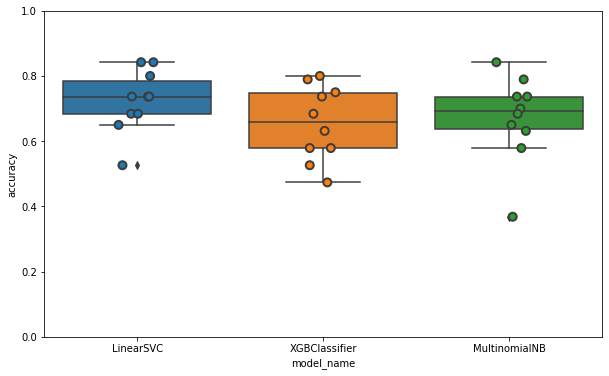

CPU times: user 552 ms, sys: 568 ms, total: 1.12 s
Wall time: 1min 3s


In [76]:
%%time
print('Only Tf-Idf _________________________')
cv_df = Parallel_CV_across_models(df_TfIdf, df.Root_Cause, features="tf-idf")

In [80]:
med_df1 = cv_df.groupby('model_name',as_index=False).agg({'accuracy':[np.median, np.mean]})
#med_df1.drop(med_df1.index[med_df1.model_name == "MultinomialNB"], axis=0, inplace=True)
med_df1

model_name  accuracy          
                    median      mean
0      LinearSVC  0.736842  0.723947
1  MultinomialNB  0.692105  0.671842
2  XGBClassifier  0.657895  0.655000

In [81]:
med_df1.columns = med_df1.columns.droplevel(0)
med_df1 =  med_df1.rename(columns={med_df1.columns[0]:"Classifier", 
                                   med_df1.columns[1]:"Median Accuracy", med_df1.columns[2]:"Mean Accuracy"})
med_df1 = med_df1.assign(Client = "BMO", Option_Considered="Longest Segment (Longest Transcription)", Notebook_Version = 2.0,
                        Features = "Tf-Idf Vectorization Model", ToTal_Features = df_TfIdf.shape[1],
                        Data = "Transcriptions + cspro_notes", Data_Points = df.shape[0])
col = med_df1.columns.tolist()
med_df1 = med_df1[col[3:]+col[:3]]
med_df1 = med_df1.assign(Null_accuracy=baseline)

med_df1.to_csv("../Data/Experiments_sheets/BMO_TfIdf_LongestTranscriptV2.csv",index=False)

In [ ]:
%%time
print('Only Word Embeddings (Normalized to Unit Vector) _________________________')
cv_df2 = Parallel_CV_across_models(test2, y_test)

In [ ]:
med_df2 = cv_df2.groupby('model_name',as_index=False).agg({'accuracy':[np.median, np.mean]})
med_df2.drop(med_df2.index[med_df2.model_name == "MultinomialNB"], axis=0, inplace=True)
med_df2

In [ ]:
med_df2.columns = med_df2.columns.droplevel(0)
med_df2 =  med_df2.rename(columns={med_df2.columns[0]:"Classifier", 
                                   med_df2.columns[1]:"Median Accuracy", med_df2.columns[2]:"Mean Accuracy"})
med_df2 = med_df2.assign(Client = "Meijer", Option_Considered="AllSegmentsConcatenated", Notebook_Version = 2.0,
                        Features = "Word2Vec Model (Non-Normalized)", ToTal_Features = stack_non_normalized.shape[1],
                        Data = "Transcriptions", Data_Points = stack_non_normalized.shape[0])
col = med_df2.columns.tolist()
med_df2 = med_df2[col[3:]+col[:3]]
med_df2 = med_df2.assign(Baseline_accuracy=baseline)

experiment_table = pd.concat([med_df1,med_df2],axis=0)
experiment_table.to_csv("../Data/Meijer_W2V_1_AllSegmentsConcatenated_Exp.csv",index=False)

### Why Multinomial NB not working

In [ ]:
model = MultinomialNB(alpha=1e-2)

In [ ]:
X_train = stack[:170]
y_train = df.Root_Cause.iloc[:170]
model.fit(X_train,y_train)